In [1]:
import pandas as pd # algebraic computations , read and write to csv 

import numpy as np # linear algebra and arrays muniplication 

import requests, zipfile, io    # Needed to download and extract the data sets of dev and eval 

# from pandarallel import pandarallel       # Parallel computation on data frames
import time                               # measure excution time of some functions

############  importing the data visualization libraries :##############

import matplotlib.pyplot as plt
import seaborn as sns

############  Import Classifiers #################

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB

# Importing a model to split the training set from the evaluation set
from sklearn.model_selection import train_test_split 

############  Evaluation Metric  #################
from sklearn.metrics import f1_score , make_scorer

############  GridSearchCV #################
from sklearn.model_selection import GridSearchCV

################## Tuxtual data prprocessing ##################
from sklearn. feature_extraction.text import TfidfVectorizer 
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image
#
import nltk
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer ,word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#### some libraries must be downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('pos_tag')
nltk.download('averaged_perceptron_tagger') 

%matplotlib inline
plt.style.use('seaborn-notebook' ) # plotting style

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### download and extract the data sets and make data frames for development and evaluation 

In [2]:
def download_dataset(zip_file_url):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    
download_dataset('https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip')



In [3]:
dev_df = pd.read_csv('./DSL2122_january_dataset/development.csv')    
eval_df = pd.read_csv('./DSL2122_january_dataset/evaluation.csv')

## Duplicates Removal

In [4]:
# Since we have no background of which tweet has the priority (The 2 tweets are identical in every feature values and not in the class label) and since the duplicated raws are only 0.25% of the whole dataset we decided to discard them 
def Remove_duplicated (df) :
    x = list(df.drop(["sentiment"] , axis=1).columns)
    df_drop_duplicates = df.copy(deep=True)
    df_drop_duplicates.drop_duplicates(subset = x ,keep=False , inplace = True )
    print("*" * 50 ,"\n" ,f"len data set before remove duplication is  {len(df)} samples")
    print("*" * 50 ,"\n" ,f"The ratio of duplicated samples in the data set is  {100*(len(df) -len(df_drop_duplicates))/len(df) :0.3f} %")
    print("*" * 50 ,"\n" ,f"len data set after remove duplication is  {len(df_drop_duplicates)} samples")
    return df_drop_duplicates

In [5]:
df_drop_duplicates = Remove_duplicated(dev_df)

************************************************** 
 len data set before remove duplication is  224994 samples
************************************************** 
 The ratio of duplicated samples in the data set is  0.247 %
************************************************** 
 len data set after remove duplication is  224438 samples


# Textual Feature sentamint analysis

####  Analyzing user Feature 

In [6]:
# We will make a copy for data exploration so we don't change the oriniginal data frame 
df_explor = df_drop_duplicates.copy(deep=True)

In [7]:
print(f" the cardinality of the user feature is {df_explor.user.nunique()}")

 the cardinality of the user feature is 10647


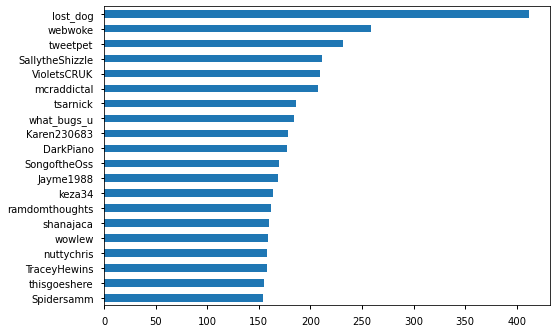

In [8]:
# plot the users with 20 highest number of reviews 
df_explor["user"].value_counts()[:20].sort_values(ascending=True).plot.barh()
plt.savefig("top 20 frequent tweet users ")
plt.show()

##### splitting the Data to positive and Negative sentiments

In [9]:
df_positive = df_explor[df_explor['sentiment'] == 1]
df_neg = df_explor[df_explor['sentiment'] == 0]

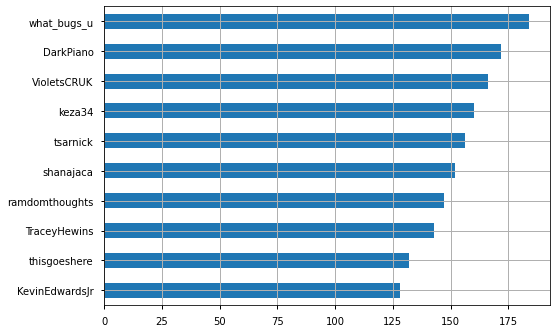

In [10]:
# Positive users 
df_positive['user'].value_counts().nlargest(10).sort_values(ascending = True).plot.barh()
plt.grid()

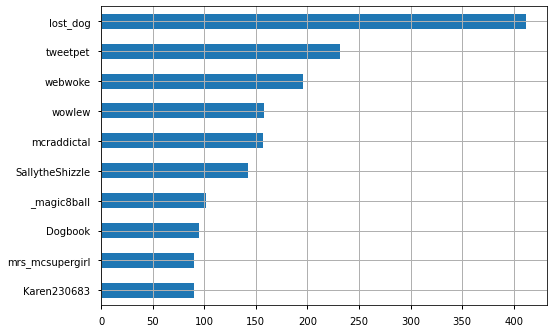

In [11]:
# negative users 
df_neg['user'].value_counts().nlargest(10).sort_values(ascending = True).plot.barh()

plt.grid()

#### some examples of how some "users" are discriminitive an can be useful for analysis

In [12]:
# Negative user
mask = df_explor['user']  == 'lost_dog' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
0            412
dtype: int64

In [13]:
# Positive user
mask = df_explor['user']  == 'what_bugs_u' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            184
dtype: int64

In [14]:
df_explor['user'] = df_explor['user'].astype("string")

#### Analyzing Hashtags

In [15]:
def extract_hashtags(document) :
    ht = re.findall(r'#(\w+)' , document)
    if len(ht) > 0:
        hashtags = ' '.join([w.strip().lower() for w in ht ])
    else :
        hashtags = np.nan
    return hashtags 

In [16]:
df_explor['hashtags'] = df_explor['text'].apply(lambda text : extract_hashtags(text) )

In [17]:
pd.set_option("display.max_rows" , 300)
df_explor['hashtags'][df_explor['hashtags'].notna()]

40                jonaskevin
85              clothdiapers
143                wolverine
144       tobaccochewingdick
164               myweakness
                 ...        
224835                  nola
224851            apprentice
224856           musicmonday
224887                    ff
224920                    ff
Name: hashtags, Length: 6478, dtype: object

In [18]:
# just for exploration we replace the samples that don't contain hashtags with 'nohashtag'
df_explor.hashtags.fillna(value = 'nohashtag',inplace=True)

In [19]:
all_hashtags = list(set(df_explor['hashtags']))

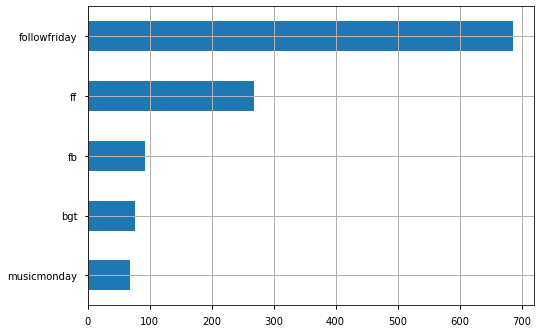

In [20]:
# All Hashtags 
df_explor['hashtags'][df_explor['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()
# plt.xticks(rotation=45)

In [21]:
df_positive = df_explor[df_explor['sentiment'] == 1]
df_neg = df_explor[df_explor['sentiment'] == 0]

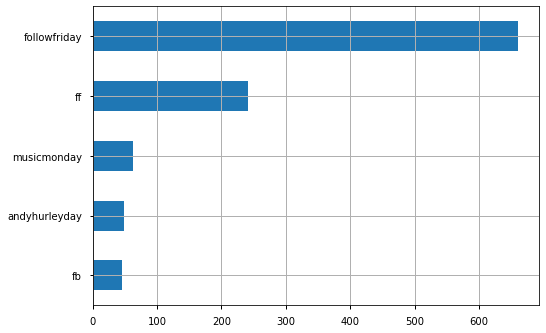

In [22]:
# Positive hashtags 
df_positive['hashtags'][df_positive['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()


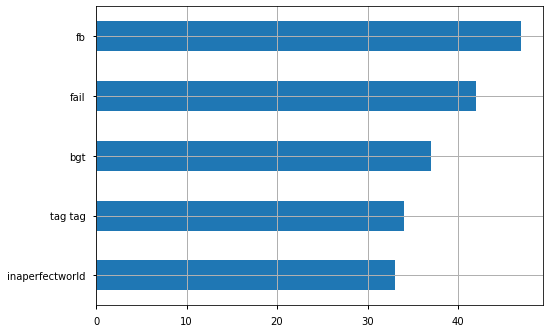

In [23]:
# negative hashtags 
df_neg['hashtags'][df_neg['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()


#### some examples of how some "Hashtags" are discriminitive an can be useful for analysis

In [24]:
mask = df_explor['hashtags']  == 'followfriday' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            660
0             26
dtype: int64

In [25]:
mask = df_explor['hashtags']  == 'ff' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            241
0             28
dtype: int64

In [26]:
mask = df_explor['hashtags']  == 'fail' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
0            42
1            10
dtype: int64

In [27]:
mask = df_explor['hashtags']  == 'idiot' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            20
dtype: int64

In [28]:
df_explor['user'] = df_explor["user"].apply(lambda text :  "user" +str(text).strip())
df_explor['text'] = df_explor['text'] + df_explor["user"]

##### * Cleaning Text :

In [29]:
additional  = ['rt','rts','retweet', "tweet", "day" , "today","tonight" ,"tomorrow","twitter", 'ittt','one', 'two', 'go','goes', 'get', 'also', 'however', 'tells' , 'you' , 'youtube' , 'just']
swords = set().union(ENGLISH_STOP_WORDS,additional)
negations =  ['not', "don't", "didn't", "isn't", 'isnt', 'dont', 'didnt', "can't", 'cant', "couldn't", 'couldnt', "wouldn't", 'wouldnt',"wasn't", 'wasnt', "haven't", 'havent', "hasn't", "hadn't", 'hadnt' 'hasnt', "wasn't", "weren't", 'wasnt', 'werent', "haven't", 'havent', "hasn't", 'hasnt', 'aint', "ain't"]
swords.difference_update(negations)
   

In [30]:
def concat_negations(doc):
    negations = ['not', "don't", "didn't", "isn't", 'isnt', 'dont', 'didnt', "can't", 'cant', "couldn't", 'couldnt', "wouldn't", 'wouldnt',
                "wasn't", 'wasnt', "haven't", 'havent', "hasn't", "hadn't", 'hadnt' 'hasnt', "wasn't", "weren't", 'wasnt', 'werent', "haven't",
                'havent', "hasn't", 'hasnt', 'aint ', "ain't"]
    x = doc.split()
    cleaned = []

    skip_word = False
    skip_count = 0
    for i in range(len(x)):

        if skip_count == 1:
            skip_word = False
            skip_count = 0

        if not skip_word:# if we already concat negations with next word, skip since it is already present
            if x[i] in negations:
                # if neg is not last word, I can concat
                if(i+1) < len(x):
                    cleaned.append(x[i]+x[i+1])
                    skip_word = True

            else: #if is not a negation, I can put as it is
                cleaned.append(x[i])
        else:
            skip_count = 1
    
    return ' '.join([w for w in cleaned])

In [31]:
def cleaning_text(document):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    # stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    document = str(document)
    # document = spelling_correction(document)
    tokens = []
    tweets_stem = [] 
    hashtags = ''
    ################# Text Cleaning  
    document = re.sub(r'[0-9_]+' , '' , document) # digits
    document = re.sub(r'@[A-Za-z0-9_]+' , '' , document) # remove @  
    ht = re.findall(r'#(\w+)' , document)             # extract  hashtages
    if len(ht) > 0:
        hashtags = ' '.join([w for w in ht if w not in swords])  
    document = re.sub(r"n't", " not ", document)
    document = re.sub(r"nt", " not ", document)
    document = re.sub(r"cannot", " can't ", document)
    document = concat_negations(document)
    document = re.sub(r"\#[A-Za-z0-9_]+", hashtags , document)
    document = re.sub('https?://\S+|www\.\S+', '', document)
    document = re.sub(r"what's", "what is ", document)
    document = re.sub(r"\'s", " ", document)
    document = re.sub(r"\'re", " are ", document)
    document = re.sub(r"\'d", " would ", document)
    document = re.sub(r"\'ll", " will ", document)
    document = re.sub(r"ittt", " it ", document)
    document = re.sub(r"livingg", " living", document)
    document = re.sub(r"\'scuse", " excuse ", document)
    document = re.sub(r"\'re", " are ", document)
    document = re.sub(r"imma", "  ", document)
    document = re.sub(r"I'm", "  ", document)
    document = re.sub(r"wid", "with", document)
    document = re.sub(r"problemooo", "problem", document)
    document = re.sub(r"frnds", "friends", document)
    document = re.sub(r"ive", "I have", document)
    document = re.sub(r"\'ve", " have ", document)
    ############ Tokinizing the documnets and extract the tokens 
    # document = tokenizer.tokenize(document)
    
    #### Make function to compact everything ####
    
    doc = pos_tag(tokenizer.tokenize(document))
    
    for token , tag in doc :
        if token not in string.punctuation and token not in swords and len(token) > 2 : 
            tokens.append((token ,tag))
    for word , tag in tokens:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = lemmatizer.lemmatize(word ,wntag)
        if lemma not in swords:
            tweets_stem.append(lemma)  # append to the list
    #### Stemming and extracting the route form of the words
    lemmed_output = ' '.join([w for w in tweets_stem])
    return lemmed_output


In [32]:
# debugging the cleaning function 
x = "you  ive just like to that Darkpiano that's i've talk too much sunshin there's don't livingg YOU've #love #hate_my_mug ittt don't do not  aa imma grass listen oasi read burnt i'll www.tweeteradder.com mean   "

cleaning_text(x)

'like darkpiano talk sunshin not live love hatemymug love hatemymug notdo notaa grass listen oasi read bur noti mean'

In [34]:
### un comment this block of code only if you are using distributed system with parallel computing 
'''from pandarallel import pandarallel

#### apply parallel mapping to speed up the process of applying functions to data frames
pandarallel.initialize()
import time
t = time.time()

df_explor['cleaned_text'] = df_explor.text.parallel_apply(lambda text : cleaning_text(text))

eval_df['cleaned_text'] = eval_df.text.parallel_apply(lambda text : cleaning_text(text))
print(f'Time taken for processing: {round(time.time()-t)} seconds')'''

"from pandarallel import pandarallel\n\n#### apply parallel mapping to speed up the process of applying functions to data frames\npandarallel.initialize()\nimport time\nt = time.time()\n\ndf_explor['cleaned_text'] = df_explor.text.parallel_apply(lambda text : cleaning_text(text))\n\neval_df['cleaned_text'] = eval_df.text.parallel_apply(lambda text : cleaning_text(text))\nprint(f'Time taken for processing: {round(time.time()-t)} seconds')"

In [35]:
##### apply the cleaning function on the text feature
df_explor['cleaned_text'] = df_explor.text.apply(lambda text : cleaning_text(text))

In [36]:
##### check the output of the mapping function 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
df_explor[['cleaned_text' , 'text' , 'sentiment']][:5]

,cleaned_text,text,sentiment
0,yes talk help lot judgme not ... notences end know mean userkillandra,"@MissBianca76 Yes, talking helps a lot.. going through it, there's no judgment... most sentences end with &quot;you know what I mean&quot; userKillandra",1
1,sunshine live lie grass listen oasis read bur notalreadyuserimlisacowan,SUNSHINE. livingg itttt. imma lie on the grass listening to oasis reading burnt alreadyuserIMlisacowan,1
2,iphone useryaseminx,@PleaseBeMine Something for your iphone useryaseminx3,1
3,notget party usernosurprises,@GabrielSaporta couldn't get in to the after party. userno_surprises,0
4,awww andy mean notmaccas userrhishortstack,@bradiewebbstack awww is andy being mean again? Now i want maccas. userRhi_ShortStack,0


# tfidf Vectoraization for Text Exploration

In [37]:
x = df_explor['cleaned_text']
vectorizer = TfidfVectorizer(use_idf=True, norm=False , smooth_idf=True, lowercase=True ,ngram_range=(1,2), max_features=1000)
vecs = vectorizer.fit_transform(x)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
# df.head()

In [38]:
#take the tfidf values Sum accross all documents to \
# sort the features in decending order accordingly 
freq = df.T.sum(axis=1)

#### check for hashtags in the top tfidf terms 

In [39]:
sorted_freq = freq.sort_values(ascending =False).reset_index()

In [40]:
sorted_freq[sorted_freq["index"]== "followfriday"]

,index,0
280,followfriday,5307.898657


In [41]:
sorted_freq[sorted_freq["index"]== "fail"]

,index,0
289,fail,5163.391594


#### check for users in the top tfidf terms 

In [42]:
# sorted_freq = freq.sort_values(ascending =False).reset_index()

In [43]:
sorted_freq[sorted_freq['index'].str.contains("user")]

,index,0
203,usertweeteradder,6757.069422
204,vip usertweeteradder,6757.069422
522,userlostdog,3006.739596
523,home userlostdog,3006.739596
874,usertweetpet,1825.914421
906,comuserwebwoke,1763.866040
924,clean usertweetpet,1722.299525


## Word Cloud Analysis Text Visualization

In [73]:
def show_wordcloud (data,  stopwords , title = None ):
    wordcloud = WordCloud(background_color='white',max_words=100, max_font_size=40, scale=3, random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud , interpolation='bilinear')
    wordcloud.to_file(f"./{title}.png")
    plt.show()

In [74]:
word_Cloud_df = df_explor[["cleaned_text" , "sentiment"]].copy(deep=True)

In [75]:
Positive = " ".join(tweet for tweet in word_Cloud_df[word_Cloud_df["sentiment"]== 1].cleaned_text)
Negative = " ".join(tweet for tweet in word_Cloud_df[word_Cloud_df["sentiment"]==0].cleaned_text)

#### Positive WordCloud

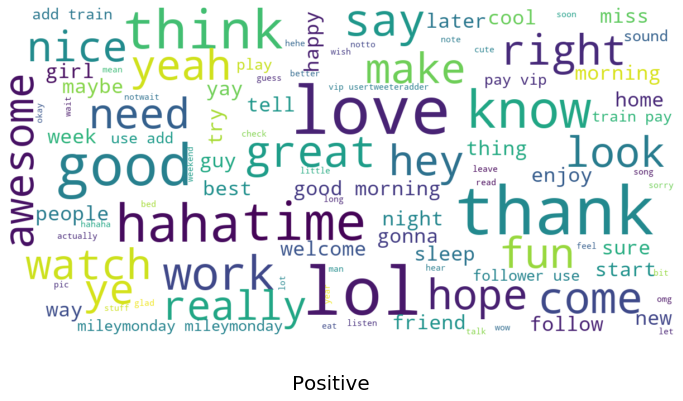

In [76]:
show_wordcloud(Positive,stopwords=swords, title='Positive')

#### Negative WordCloud

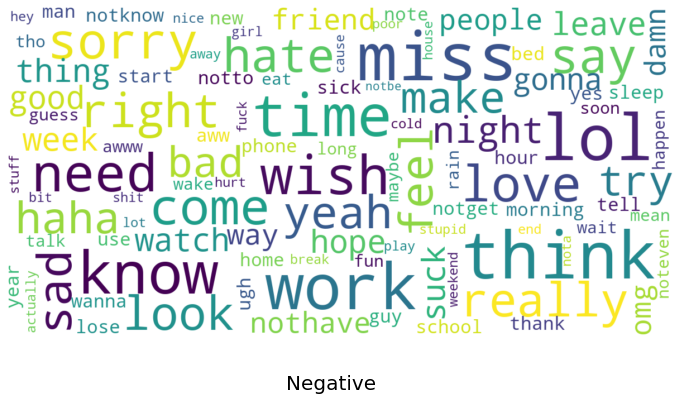

In [77]:
show_wordcloud (Negative,stopwords=swords, title= 'Negative')